In [18]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [19]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"

# tags = ['2024-04-12-15-31-26']
# filters = {"tags": {"$in": tags}}
# tags = ["2024-05-16-14-08-32"]
tags = ["2024-05-16-15-02-46"]
filters = {"tags": {"$in": tags}, "state": "finished"}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [20]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
# df = df[df['Evaluation/Mean_Returns'] != -100]

ncols, nrows = df["ncols"][0], 40
df

100%|██████████| 5/5 [00:00<00:00, 40329.85it/s]


,_wandb,_timestamp,Evaluation/Entropies,Evaluation/Mean_Returns,Evaluation/Discounted_Returns,_step,Evaluation/Mean_Entropy,Evaluation/Mean_Discounted_Returns,trajectories,Evaluation/Timesteps,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,{'runtime': 2241},1.715867e+09,"{'_type': 'histogram', 'bins': [0.251315593719...",-20.500000,"{'_type': 'histogram', 'bins': [-22, -21.95312...",0,0.271823,-20.500000,"[[468, 456, 444, 432, 420, 421, 422, 423, 424,...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
1,{'runtime': 200},1.715865e+09,"{'bins': [0.4135550260543823, 0.41517800092697...",-21.333334,"{'_type': 'histogram', 'bins': [-24, -23.92187...",0,0.443282,-21.333334,"[[468, 456, 444, 432, 420, 421, 422, 423, 424,...","{'bins': [19, 19.078125, 19.15625, 19.234375, ...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
2,{'runtime': 103},1.715865e+09,"{'_type': 'histogram', 'bins': [0.576255440711...",-31.833334,"{'_type': 'histogram', 'bins': [-42, -41.6875,...",0,0.690324,-31.833334,"[[468, 456, 444, 432, 420, 420, 420, 432, 420,...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
3,{'runtime': 24},1.715865e+09,"{'_type': 'histogram', 'bins': [0.778736591339...",-25.666666,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0...",0,0.811991,-25.666666,"[[468, 456, 444, 432, 433, 434, 435, 423, 424,...","{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity
4,{'runtime': 10},1.715865e+09,"{'bins': [0.8858324885368347, 0.88651716709136...",-21.666666,"{'_type': 'histogram', 'bins': [-43, -42.57812...",0,0.901544,-21.666666,"[[468, 456, 456, 456, 456, 457, 445, 446, 447,...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ...",...,0.3,4,identity,coordinate,0.000001,UCT,6,visit,15,identity


In [21]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()
aggregated_trajectories


policy_combination  planning_budget
visit+UCT           16                 [[468, 456, 456, 456, 456, 457, 445, 446, 447,...
                    64                 [[468, 456, 444, 432, 433, 434, 435, 423, 424,...
                    256                [[468, 456, 444, 432, 420, 420, 420, 432, 420,...
                    1024               [[468, 456, 444, 432, 420, 421, 422, 423, 424,...
                    4096               [[468, 456, 444, 432, 420, 421, 422, 423, 424,...
Name: trajectories, dtype: object

In [22]:
# remove all trajectories with a length of 100
print(aggregated_trajectories.apply(lambda x: len(x)).sum())
filtered_aggregated_trajectories = aggregated_trajectories.apply(lambda x: [traj for traj in x if len(traj) != 200])
# check the total number of trajectories
filtered_aggregated_trajectories.apply(lambda x: len(x)).sum()

30


30

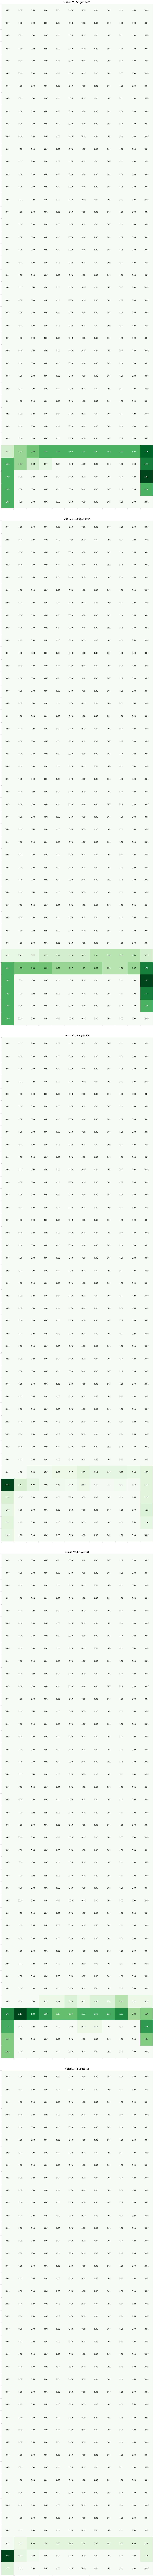

In [23]:
# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in filtered_aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    if n_policies == 1:
        ax = axs[i]
    elif n_budgets == 1:
        ax = axs[j]
    else:
        ax = axs[i, j]
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.2f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")

plt.tight_layout()
# plt.savefig("outfiles/cliff_heurstic_density.pdf")
plt.show()


In [24]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(nrows * n_budgets, nrows))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()

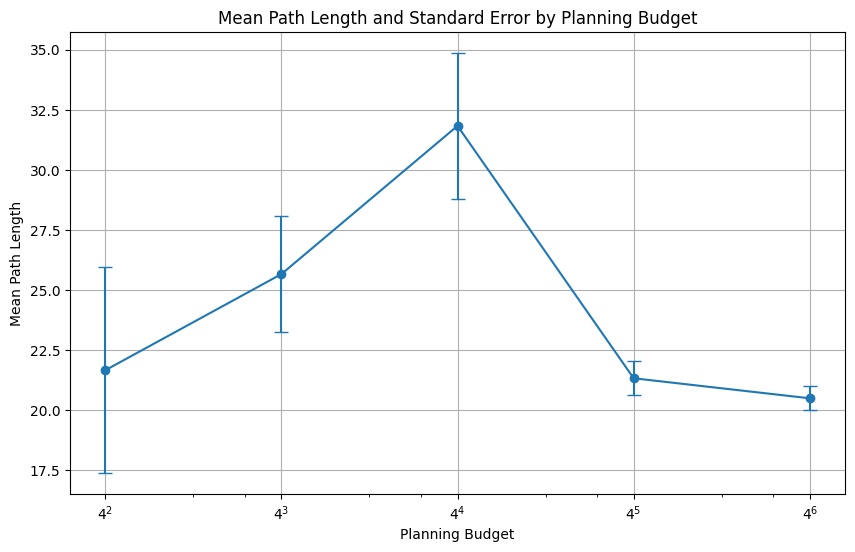

In [25]:



df["path_lengths"] = df["trajectories"].apply(lambda x: [len(traj) for traj in x if len(traj) != 200])
# Assuming 'df' is your dataframe and it contains 'path_lengths' and 'planning_budget' columns

# Filter the dataframe to include only budgets >= 6
df_filtered = df # df[df['planning_budget'] >= 6].copy()

# Calculate mean and standard error for each path
df_filtered.loc[:, 'mean_path_length'] = df_filtered['path_lengths'].apply(np.mean)
df_filtered.loc[:, 'stderr_path_length'] = df_filtered['path_lengths'].apply(lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))

# Group by 'planning_budget' and calculate the mean and standard error for each group
grouped = df_filtered.groupby('planning_budget').agg({'mean_path_length': 'mean', 'stderr_path_length': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(grouped['planning_budget'], grouped['mean_path_length'], yerr=grouped['stderr_path_length'], fmt='-o', capsize=5)
plt.xlabel('Planning Budget')
plt.ylabel('Mean Path Length')
plt.title('Mean Path Length and Standard Error by Planning Budget')
plt.xscale('log', base=4)
plt.grid(True)
plt.show()


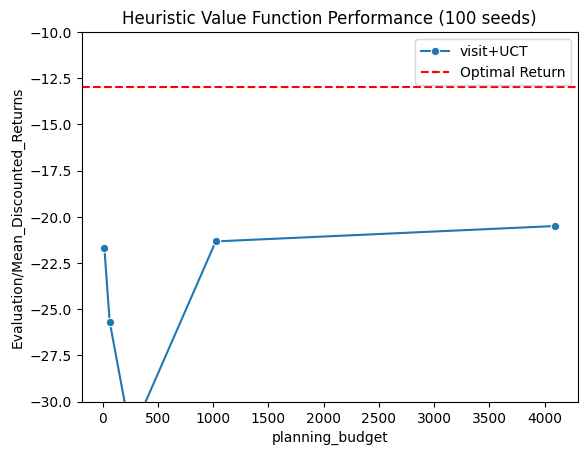

In [26]:
# plot Evaluation/Mean_Discounted_Returns from df vs planning_budget for each policy_combination

sns.lineplot(data=df, x='planning_budget', y='Evaluation/Mean_Discounted_Returns', hue='policy_combination', marker='o')
optimal_value = -13
plt.axhline(optimal_value, color='red', linestyle='--', label='Optimal Return')
# set y axis to go between -30 and -10
plt.ylim(-30, -10)
plt.legend()
plt.title('Heuristic Value Function Performance (100 seeds)')
plt.savefig("outfiles/heuristic_value_function_performance.pdf")
plt.show()
